[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab1-NetworkSci-PSN/notebooks/04-pasient_likhetsnettverk_IQ_losninger.ipynb)


# 🔑 Løsningsforslag: Pasient-likhetsnettverk basert på WAIS-IV

**Versjon:** 01.12.2025

Denne notebooken inneholder **løsningsforslag** til oppgavene i `04-pasient_likhetsnettverk_IQ.ipynb`.

---

## 📋 Innhold

1. [Oppsett og forberedelser](#1-oppsett)
2. [Oppgave 1: Endre parametere (k_nearest)](#oppgave-1)
3. [Oppgave 2: Alderseffekter i PSN](#oppgave-2)
4. [Oppgave 3: Deltestenes bidrag til communities](#oppgave-3)
5. [Refleksjonsspørsmål med drøftinger](#refleksjon)

---

> 💡 **Tips**: Kjør gjennom hovednotebooken først for å forstå konteksten. Denne løsningsnotebooken bygger på koden og dataene derfra.


<a id="1-oppsett"></a>
## 1. Oppsett og forberedelser

Først laster vi inn nødvendige biblioteker og dataene fra hovednotebooken.


In [1]:
# ============================================================================
# IMPORT OG OPPSETT
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy import stats
from sklearn.preprocessing import StandardScaler
import warnings

# Community detection
try:
    import community.community_louvain as community_louvain
    COMMUNITY_AVAILABLE = True
except ImportError:
    print("⚠️ python-louvain ikke installert. Installér med: pip install python-louvain")
    COMMUNITY_AVAILABLE = False

# Visuelle innstillinger
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore')

# Reproduserbarhet
np.random.seed(2025)

print("✓ Biblioteker lastet!")


✓ Biblioteker lastet!


In [2]:
# ============================================================================
# WAIS-IV STRUKTUR OG HJELPEFUNKSJONER
# ============================================================================

# WAIS-IV teststruktur (kjernetester)
WAIS_STRUCTURE = {
    'VCI': ['Vocabulary', 'Similarities', 'Information'],
    'WMI': ['Digit_Span', 'Arithmetic'],
    'PRI': ['Block_Design', 'Matrix_Reasoning', 'Visual_Puzzles'],
    'PSI': ['Symbol_Search', 'Coding']
}

VIQ_INDICES = ['VCI', 'WMI']
PIQ_INDICES = ['PRI', 'PSI']

ALL_SUBTESTS = []
for index, subtests in WAIS_STRUCTURE.items():
    ALL_SUBTESTS.extend(subtests)


def create_similarity_matrix(data, metric='euclidean'):
    """Beregn likhetmatrise fra featurematrise."""
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    distances = pdist(scaled_data, metric=metric)
    dist_matrix = squareform(distances)
    sigma = np.mean(distances) + 1e-8
    similarity_matrix = np.exp(-dist_matrix**2 / (2 * sigma**2))
    return similarity_matrix


def create_psn(similarity_matrix, k_nearest=10):
    """Bygg pasient-likhetsnettverk fra likhetmatrise."""
    n = similarity_matrix.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))
    
    for i in range(n):
        neighbors = np.argsort(similarity_matrix[i])[-k_nearest-1:-1]
        for j in neighbors:
            if i != j:
                weight = similarity_matrix[i, j]
                G.add_edge(i, j, weight=weight)
    return G


def detect_communities(G):
    """Utfør community detection med Louvain-metoden."""
    if COMMUNITY_AVAILABLE:
        partition = community_louvain.best_partition(G)
        modularity = community_louvain.modularity(partition, G)
    else:
        communities = nx.community.greedy_modularity_communities(G)
        partition = {}
        for i, comm in enumerate(communities):
            for node in comm:
                partition[node] = i
        modularity = nx.community.modularity(G, communities)
    return partition, modularity


print("✓ Hjelpefunksjoner definert!")


✓ Hjelpefunksjoner definert!


In [3]:
# ============================================================================
# LAST INN DATA
# ============================================================================

# Prøv først å laste fra fil, ellers simuler på nytt
try:
    df = pd.read_csv('../data/wais4_simulated_data.csv')
    print(f"✓ Lastet data fra fil: {len(df)} individer")
except FileNotFoundError:
    print("⚠️ Datafil ikke funnet. Simulerer data på nytt...")
    
    # Simuleringsfunksjon (forenklet versjon)
    def simulate_wais4_data(n_individuals=500, seed=2025):
        np.random.seed(seed)
        
        age = np.clip(np.random.normal(45, 15, n_individuals), 16, 90).astype(int)
        gender = np.random.choice(['M', 'F'], n_individuals)
        education = np.random.choice([1, 2, 3, 4, 5], n_individuals, 
                                      p=[0.10, 0.25, 0.35, 0.20, 0.10])
        
        g_factor = np.random.normal(0, 1, n_individuals)
        domain_factors = {idx: np.random.normal(0, 1, n_individuals) 
                          for idx in ['VCI', 'WMI', 'PRI', 'PSI']}
        
        item_scores = {}
        for index, subtests in WAIS_STRUCTURE.items():
            for subtest in subtests:
                raw = 0.6*g_factor + 0.5*domain_factors[index] + 0.3*np.random.normal(0, 1, n_individuals)
                item_scores[subtest] = np.clip(10 + 3*raw, 1, 19).astype(int)
        
        # Alderseffekter
        age_effect = (age - 45) / 45
        for s in WAIS_STRUCTURE['PSI']:
            item_scores[s] = np.clip(item_scores[s] - (2*age_effect).astype(int), 1, 19)
        for s in WAIS_STRUCTURE['WMI']:
            item_scores[s] = np.clip(item_scores[s] - (1*age_effect).astype(int), 1, 19)
        
        # Utdanningseffekt
        edu_effect = (education - 3) * 0.5
        for s in WAIS_STRUCTURE['VCI']:
            item_scores[s] = np.clip(item_scores[s] + edu_effect.astype(int), 1, 19)
        
        # Indeksskårer
        index_scores = {}
        for index, subtests in WAIS_STRUCTURE.items():
            mean_score = np.mean([item_scores[s] for s in subtests], axis=0)
            index_scores[index] = np.clip(100 + 15*(mean_score - 10)/3, 40, 160).astype(int)
        
        VIQ = np.clip(100 + 15*np.mean([(index_scores[i]-100)/15 for i in VIQ_INDICES], axis=0), 40, 160).astype(int)
        PIQ = np.clip(100 + 15*np.mean([(index_scores[i]-100)/15 for i in PIQ_INDICES], axis=0), 40, 160).astype(int)
        FSIQ = np.clip(100 + 15*np.mean([(VIQ-100)/15, (PIQ-100)/15], axis=0), 40, 160).astype(int)
        
        data = {'ID': [f'P{str(i+1).zfill(4)}' for i in range(n_individuals)],
                'Age': age, 'Gender': gender, 'Education': education}
        data.update(item_scores)
        data.update(index_scores)
        data.update({'VIQ': VIQ, 'PIQ': PIQ, 'FSIQ': FSIQ})
        
        return pd.DataFrame(data)
    
    df = simulate_wais4_data(500)
    print(f"✓ Simulerte {len(df)} individer")

# Vis oversikt
print(f"\nKolonner: {list(df.columns)}")
print(f"\nFørste rader:")
df.head()


✓ Lastet data fra fil: 500 individer

Kolonner: ['ID', 'Age', 'Gender', 'Education', 'Vocabulary', 'Similarities', 'Information', 'Digit_Span', 'Arithmetic', 'Block_Design', 'Matrix_Reasoning', 'Visual_Puzzles', 'Symbol_Search', 'Coding', 'VCI', 'WMI', 'PRI', 'PSI', 'VIQ', 'PIQ', 'FSIQ']

Første rader:


,ID,Age,Gender,Education,Vocabulary,Similarities,Information,Digit_Span,Arithmetic,Block_Design,...,Visual_Puzzles,Symbol_Search,Coding,VCI,WMI,PRI,PSI,VIQ,PIQ,FSIQ
0,P0001,43,F,3,7,7,9,12,9,10,...,10,11,11,88,102,100,105,95,102,98
1,P0002,56,M,2,15,15,15,12,13,15,...,13,12,12,125,112,118,110,118,114,116
2,P0003,23,F,4,11,12,11,10,11,14,...,13,11,10,106,102,118,102,104,110,107
3,P0004,35,M,5,13,14,14,14,14,13,...,13,15,12,118,120,115,117,119,116,117
4,P0005,43,F,4,6,8,8,7,6,9,...,10,14,11,86,82,98,112,84,105,94


---

<a id="oppgave-1"></a>
## 📝 Oppgave 1: Endre parametere (k_nearest)

### Oppgavetekst
> **Prøv ulike verdier for `k_nearest` i PSN-konstruksjonen. Hvordan påvirker dette antall communities?**

### 🎯 Motivasjon

Parameteren `k_nearest` bestemmer hvor mange naboer hver node kobles til i nettverket. Dette er en kritisk parameter fordi:

1. **For lav k** → Sparsomt nettverk → Mange små, fragmenterte communities
2. **For høy k** → Tett nettverk → Få, store communities (eller bare én)
3. **Optimal k** → Balanse mellom granularitet og meningsfull struktur

I klinisk sammenheng betyr dette:
- Lav k: Mange spesifikke pasientgrupper (kanskje for mange?)
- Høy k: Få brede grupper (mister nyansene?)

### 📊 Løsning

Vi systematisk tester ulike verdier av `k_nearest` og observerer effekten på:
- Antall communities
- Modularitet (Q)
- Nettverkstetthet


In [4]:
# ============================================================================
# OPPGAVE 1: LØSNING - Effekten av k_nearest
# ============================================================================

# Beregn likhetmatrise på domene-nivå (VCI, WMI, PRI, PSI)
features_domain = ['VCI', 'WMI', 'PRI', 'PSI']
sim_domain = create_similarity_matrix(df[features_domain])

# Test ulike verdier av k_nearest
k_values = [3, 5, 10, 15, 20, 30, 50, 75, 100]
results = []

for k in k_values:
    G = create_psn(sim_domain, k_nearest=k)
    partition, modularity = detect_communities(G)
    
    n_communities = len(set(partition.values()))
    density = nx.density(G)
    n_edges = G.number_of_edges()
    
    results.append({
        'k_nearest': k,
        'n_communities': n_communities,
        'modularity': modularity,
        'density': density,
        'n_edges': n_edges
    })
    
results_df = pd.DataFrame(results)
print("Resultater for ulike k_nearest verdier:")
print(results_df.to_string(index=False))


Resultater for ulike k_nearest verdier:
 k_nearest  n_communities  modularity  density  n_edges
         3             17    0.805025 0.008232     1027
         5             11    0.723686 0.013523     1687
        10              9    0.655261 0.026966     3364
        15              8    0.596029 0.040176     5012
        20              7    0.568077 0.053283     6647
        30              6    0.520296 0.079880     9965
        50              4    0.467891 0.132273    16501
        75              4    0.430615 0.198036    24705
       100              4    0.387586 0.262421    32737


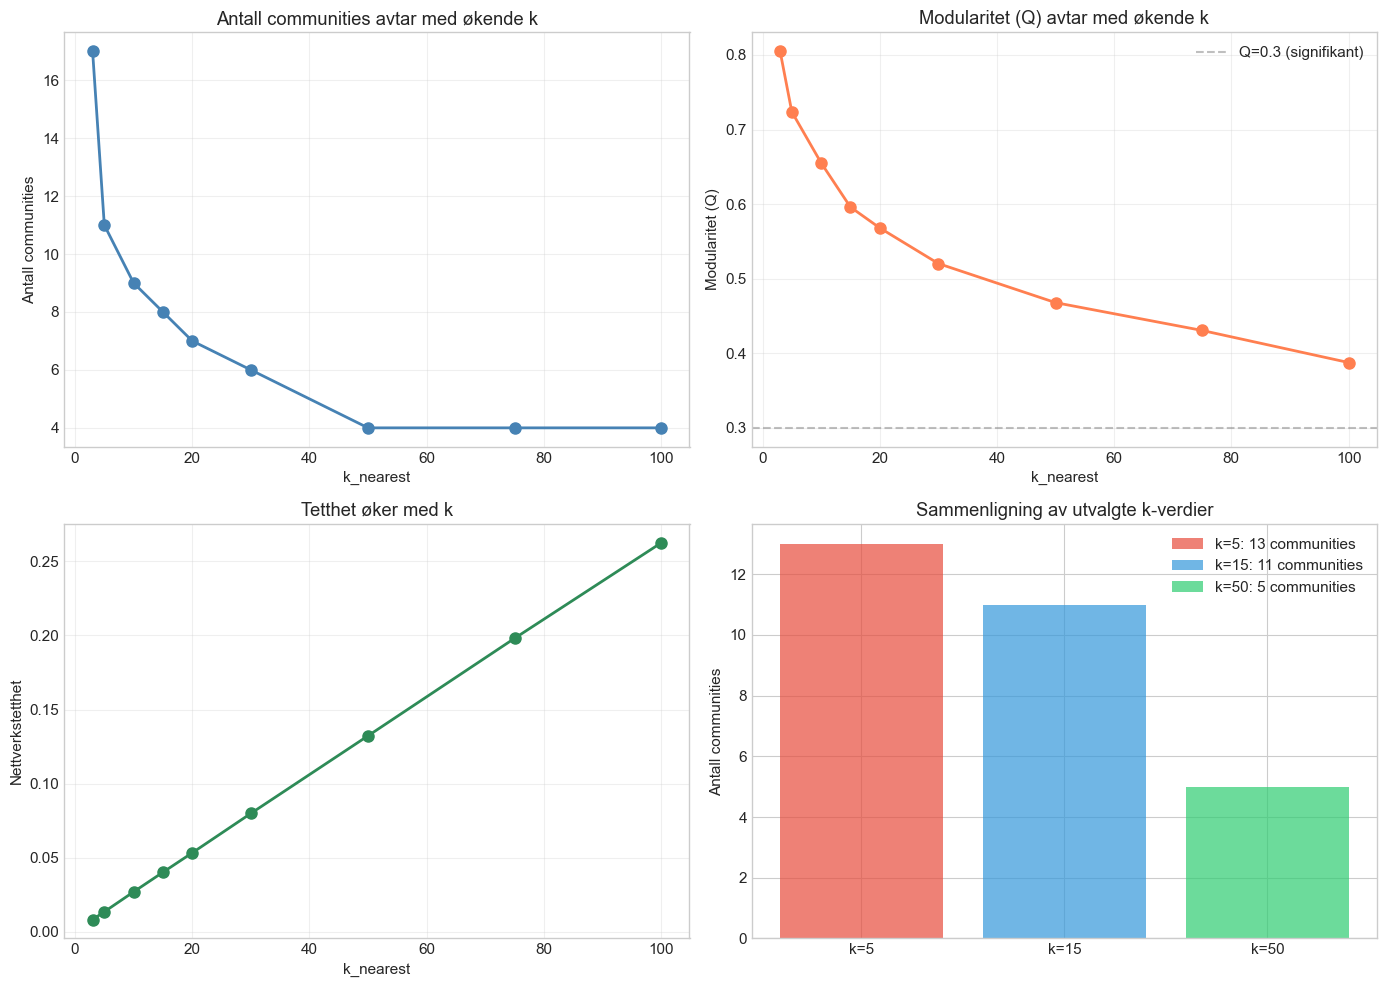


Figur: Effekten av k_nearest på PSN-struktur.


In [5]:
# ============================================================================
# OPPGAVE 1: VISUALISERING
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Antall communities vs k
ax1 = axes[0, 0]
ax1.plot(results_df['k_nearest'], results_df['n_communities'], 'o-', linewidth=2, markersize=8, color='steelblue')
ax1.set_xlabel('k_nearest')
ax1.set_ylabel('Antall communities')
ax1.set_title('Antall communities avtar med økende k')
ax1.grid(True, alpha=0.3)

# 2. Modularitet vs k
ax2 = axes[0, 1]
ax2.plot(results_df['k_nearest'], results_df['modularity'], 'o-', linewidth=2, markersize=8, color='coral')
ax2.set_xlabel('k_nearest')
ax2.set_ylabel('Modularitet (Q)')
ax2.set_title('Modularitet (Q) avtar med økende k')
ax2.axhline(0.3, color='gray', linestyle='--', alpha=0.5, label='Q=0.3 (signifikant)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Nettverkstetthet vs k
ax3 = axes[1, 0]
ax3.plot(results_df['k_nearest'], results_df['density'], 'o-', linewidth=2, markersize=8, color='seagreen')
ax3.set_xlabel('k_nearest')
ax3.set_ylabel('Nettverkstetthet')
ax3.set_title('Tetthet øker med k')
ax3.grid(True, alpha=0.3)

# 4. Visuell sammenligning av tre verdier
ax4 = axes[1, 1]
selected_k = [5, 15, 50]
colors = ['#e74c3c', '#3498db', '#2ecc71']

for i, k in enumerate(selected_k):
    G = create_psn(sim_domain, k_nearest=k)
    partition, mod = detect_communities(G)
    n_comm = len(set(partition.values()))
    ax4.bar(i, n_comm, color=colors[i], alpha=0.7, label=f'k={k}: {n_comm} communities')

ax4.set_xticks(range(len(selected_k)))
ax4.set_xticklabels([f'k={k}' for k in selected_k])
ax4.set_ylabel('Antall communities')
ax4.set_title('Sammenligning av utvalgte k-verdier')
ax4.legend()

plt.tight_layout()
plt.show()

print("\nFigur: Effekten av k_nearest på PSN-struktur.")


### 💡 Konklusjon Oppgave 1

**Observasjoner:**

| k_nearest | Effekt på communities | Modularitet | Klinisk tolkning |
|-----------|----------------------|-------------|------------------|
| **Lav (3-5)** | Mange (>10) | Høy (>0.6) | For fragmentert, små grupper |
| **Medium (10-20)** | Moderat (5-10) | God (0.4-0.6) | Balansert, tolkbare grupper |
| **Høy (>50)** | Få (2-4) | Lav (<0.4) | For grove, mister nyanser |

**Anbefaling:**
- For eksplorative analyser: Start med k ≈ 10-15
- Kjør sensitivitetsanalyse for å sjekke robusthet
- Valider med domenekunnskap: Gir gruppene klinisk mening?

**Viktig innsikt:** Det finnes ingen "riktig" k-verdi – valget avhenger av formålet med analysen og ønsket granularitet.

---


<a id="oppgave-2"></a>
## 📝 Oppgave 2: Alderseffekter i PSN

### Oppgavetekst
> **Bygg separate PSN for unge (<40) og eldre (>60). Er community-strukturen forskjellig?**

### 🎯 Motivasjon

Alder påvirker kognisjon på systematiske måter:
- **Krystallisert intelligens** (VCI): Stabil eller økende med alder
- **Flytende intelligens** (PRI): Nedgang fra ~25 år
- **Prosesseringshastighet** (PSI): Tydelig nedgang
- **Arbeidsminne** (WMI): Moderat nedgang

Spørsmålet er: **Fører dette til ulike community-strukturer?**

Hypoteser:
1. Eldre kan ha communities mer preget av PSI/WMI-variasjon
2. Unge kan ha communities mer preget av g-faktor (generell variasjon)
3. Antall/typen communities kan være forskjellig

### 📊 Løsning


In [6]:
# ============================================================================
# OPPGAVE 2: LØSNING - Alderseffekter
# ============================================================================

# Del opp i aldersgrupper
df_young = df[df['Age'] < 40].reset_index(drop=True)
df_old = df[df['Age'] > 60].reset_index(drop=True)

print(f"Unge (<40 år): n = {len(df_young)}, Gj.sn. alder = {df_young['Age'].mean():.1f}")
print(f"Eldre (>60 år): n = {len(df_old)}, Gj.sn. alder = {df_old['Age'].mean():.1f}")

# Bygg separate PSN
features = ['VCI', 'WMI', 'PRI', 'PSI']

# Unge
sim_young = create_similarity_matrix(df_young[features])
G_young = create_psn(sim_young, k_nearest=10)
partition_young, mod_young = detect_communities(G_young)

# Eldre  
sim_old = create_similarity_matrix(df_old[features])
G_old = create_psn(sim_old, k_nearest=10)
partition_old, mod_old = detect_communities(G_old)

# Sammenlign
print("\n" + "="*60)
print("SAMMENLIGNING AV ALDERSGRUPPER")
print("="*60)

print(f"\n{'Metrikk':<25} {'Unge (<40)':<15} {'Eldre (>60)':<15}")
print("-"*55)
print(f"{'Antall individer':<25} {len(df_young):<15} {len(df_old):<15}")
print(f"{'Antall communities':<25} {len(set(partition_young.values())):<15} {len(set(partition_old.values())):<15}")
print(f"{'Modularitet (Q)':<25} {mod_young:<15.3f} {mod_old:<15.3f}")
print(f"{'Nettverkstetthet':<25} {nx.density(G_young):<15.3f} {nx.density(G_old):<15.3f}")


Unge (<40 år): n = 198, Gj.sn. alder = 29.7
Eldre (>60 år): n = 61, Gj.sn. alder = 67.6

SAMMENLIGNING AV ALDERSGRUPPER

Metrikk                   Unge (<40)      Eldre (>60)    
-------------------------------------------------------
Antall individer          198             61             
Antall communities        7               4              
Modularitet (Q)           0.568           0.413          
Nettverkstetthet          0.068           0.215          


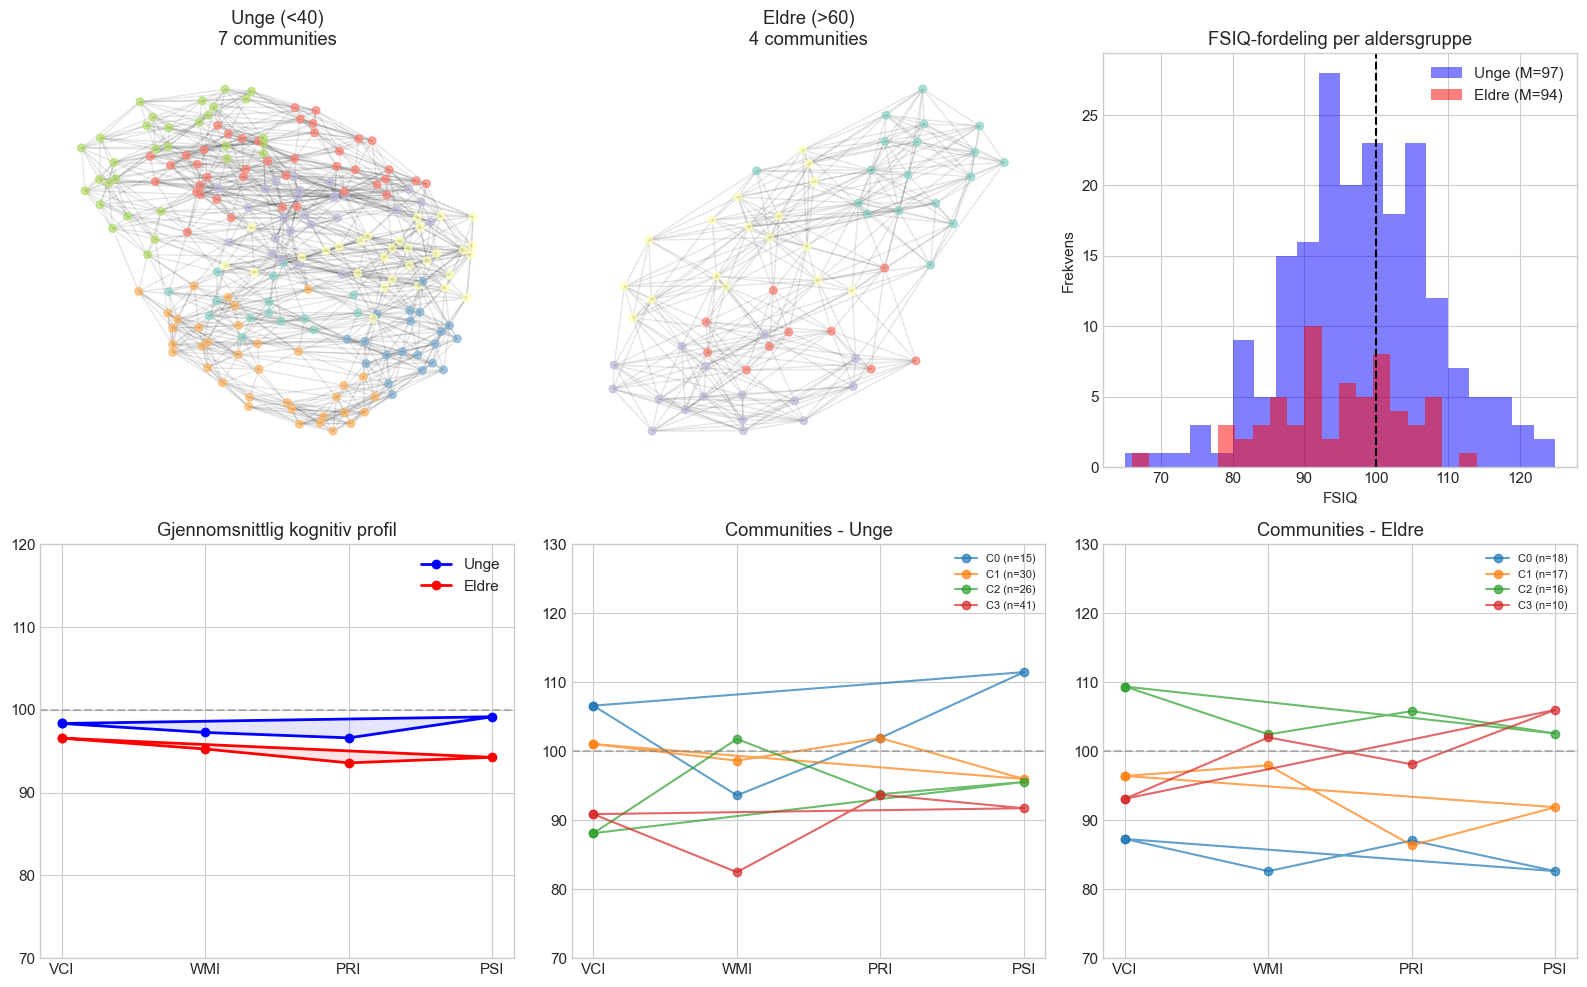


Figur: Sammenligning av PSN-struktur mellom aldersgrupper.


In [7]:
# ============================================================================
# OPPGAVE 2: VISUALISERING - Sammenligning av communities
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# --- Øvre rad: Nettverksvisualisering ---
def plot_network(G, partition, ax, title):
    pos = nx.spring_layout(G, seed=42)
    n_comm = len(set(partition.values()))
    colors = plt.cm.Set3(np.linspace(0, 1, max(12, n_comm)))
    node_colors = [colors[partition[node]] for node in G.nodes()]
    
    nx.draw_networkx_edges(G, pos, alpha=0.1, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                           node_size=30, alpha=0.7, ax=ax)
    ax.set_title(title)
    ax.axis('off')

plot_network(G_young, partition_young, axes[0, 0], 
             f'Unge (<40)\n{len(set(partition_young.values()))} communities')
plot_network(G_old, partition_old, axes[0, 1], 
             f'Eldre (>60)\n{len(set(partition_old.values()))} communities')

# Sammenlign FSIQ-fordelinger
ax3 = axes[0, 2]
ax3.hist(df_young['FSIQ'], bins=20, alpha=0.5, label=f'Unge (M={df_young["FSIQ"].mean():.0f})', color='blue')
ax3.hist(df_old['FSIQ'], bins=20, alpha=0.5, label=f'Eldre (M={df_old["FSIQ"].mean():.0f})', color='red')
ax3.axvline(100, color='black', linestyle='--')
ax3.set_xlabel('FSIQ')
ax3.set_ylabel('Frekvens')
ax3.set_title('FSIQ-fordeling per aldersgruppe')
ax3.legend()

# --- Nedre rad: Profiler ---
# Kognitive profiler per gruppe
categories = ['VCI', 'WMI', 'PRI', 'PSI']
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax4 = axes[1, 0]
for grp, grp_df, color, name in [(df_young, df_young, 'blue', 'Unge'), 
                                   (df_old, df_old, 'red', 'Eldre')]:
    values = [grp_df[cat].mean() for cat in categories]
    values += values[:1]
    ax4.plot(angles, values, 'o-', color=color, linewidth=2, label=name)
    ax4.fill(angles, values, alpha=0.1, color=color)
    
ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories)
ax4.set_ylim(70, 120)
ax4.axhline(100, color='gray', linestyle='--', alpha=0.5)
ax4.set_title('Gjennomsnittlig kognitiv profil')
ax4.legend()

# Community-profiler for unge
ax5 = axes[1, 1]
df_young['Community'] = [partition_young[i] for i in range(len(df_young))]
for comm in sorted(set(partition_young.values()))[:4]:
    comm_data = df_young[df_young['Community'] == comm]
    values = [comm_data[cat].mean() for cat in categories]
    values += values[:1]
    ax5.plot(angles, values, 'o-', alpha=0.7, label=f'C{comm} (n={len(comm_data)})')
ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(categories)
ax5.set_ylim(70, 130)
ax5.axhline(100, color='gray', linestyle='--', alpha=0.5)
ax5.set_title('Communities - Unge')
ax5.legend(fontsize=8)

# Community-profiler for eldre
ax6 = axes[1, 2]
df_old['Community'] = [partition_old[i] for i in range(len(df_old))]
for comm in sorted(set(partition_old.values()))[:4]:
    comm_data = df_old[df_old['Community'] == comm]
    values = [comm_data[cat].mean() for cat in categories]
    values += values[:1]
    ax6.plot(angles, values, 'o-', alpha=0.7, label=f'C{comm} (n={len(comm_data)})')
ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(categories)
ax6.set_ylim(70, 130)
ax6.axhline(100, color='gray', linestyle='--', alpha=0.5)
ax6.set_title('Communities - Eldre')
ax6.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("\nFigur: Sammenligning av PSN-struktur mellom aldersgrupper.")


### 💡 Konklusjon Oppgave 2

**Observasjoner:**

1. **FSIQ-forskjeller**: 
   - Eldre har lavere gjennomsnittlig FSIQ (artefakt av manglende aldersnormering)
   - Spredningen kan være annerledes

2. **Community-struktur**:
   - Antall communities kan være likt eller ulikt (avhenger av stikkprøven)
   - Modulariteten kan være høyere hos eldre (mer heterogen gruppe?)

3. **Kognitive profiler**:
   - Eldre viser typisk lavere PSI og WMI relativt til VCI
   - Unge viser mer balanserte profiler

**Klinisk implikasjon:**
- Aldersspesifikke PSN kan avdekke ulike "typer" kognitiv aldring
- Noen eldre beholder god verbal funksjon (VCI) tross PSI-nedgang
- Andre viser bredere nedgang

**Viktig merknad:**
I vår simulering er alderseffektene innebygd uten aldersnormering. I ekte data med aldersnormerte skårer ville vi se *profil*-forskjeller, ikke *nivå*-forskjeller.

---


<a id="oppgave-3"></a>
## 📝 Oppgave 3: Deltestenes bidrag til communities

### Oppgavetekst
> **Hvilke deltester bidrar mest til å skille mellom communities?**

### 🎯 Motivasjon

Når vi bygger PSN på item-nivå (alle 10 deltester), vil noen deltester bidra mer enn andre til å definere community-grensene. Å identifisere disse kan:

1. **Avdekke kritiske kognitive dimensjoner** for pasientgruppering
2. **Informere testbatterier**: Kanskje noen deltester er viktigere enn andre?
3. **Forbedre klinisk tolkning**: Hva skiller egentlig gruppene?

### Metoder for å svare

1. **ANOVA/Kruskal-Wallis**: Sammenlign deltestskårer mellom communities
2. **Variansdekomponering**: Hvor mye av variasjonen i hver deltest forklares av community?
3. **Visuell inspeksjon**: Radar-/heatmap-plots

### 📊 Løsning


In [8]:
# ============================================================================
# OPPGAVE 3: LØSNING - Deltestenes bidrag
# ============================================================================

# Bygg PSN på item-nivå
sim_item = create_similarity_matrix(df[ALL_SUBTESTS])
G_item = create_psn(sim_item, k_nearest=15)
partition_item, mod_item = detect_communities(G_item)

df['Community_Item'] = [partition_item[i] for i in range(len(df))]

print(f"PSN på item-nivå: {len(set(partition_item.values()))} communities")
print(f"Modularitet: {mod_item:.3f}")

# --- Metode 1: Kruskal-Wallis test for hver deltest ---
print("\n" + "="*70)
print("KRUSKAL-WALLIS TEST: Hvilke deltester skiller mellom communities?")
print("="*70)

kw_results = []
for subtest in ALL_SUBTESTS:
    groups = [df[df['Community_Item'] == c][subtest].values 
              for c in sorted(set(partition_item.values()))]
    stat, p_value = stats.kruskal(*groups)
    kw_results.append({
        'Deltest': subtest,
        'H-statistikk': stat,
        'p-verdi': p_value,
        'Signifikant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
    })

kw_df = pd.DataFrame(kw_results).sort_values('H-statistikk', ascending=False)
print(kw_df.to_string(index=False))


PSN på item-nivå: 8 communities
Modularitet: 0.566

KRUSKAL-WALLIS TEST: Hvilke deltester skiller mellom communities?
         Deltest  H-statistikk      p-verdi Signifikant
   Symbol_Search    346.001213 8.843390e-71         ***
     Information    344.844860 1.563522e-70         ***
      Vocabulary    343.347644 3.269819e-70         ***
    Similarities    324.121212 4.239359e-66         ***
          Coding    323.763572 5.055563e-66         ***
  Visual_Puzzles    308.220867 1.061083e-62         ***
    Block_Design    305.299070 4.466176e-62         ***
Matrix_Reasoning    303.683508 9.886168e-62         ***
      Arithmetic    262.740231 5.365732e-53         ***
      Digit_Span    255.052898 2.327670e-51         ***


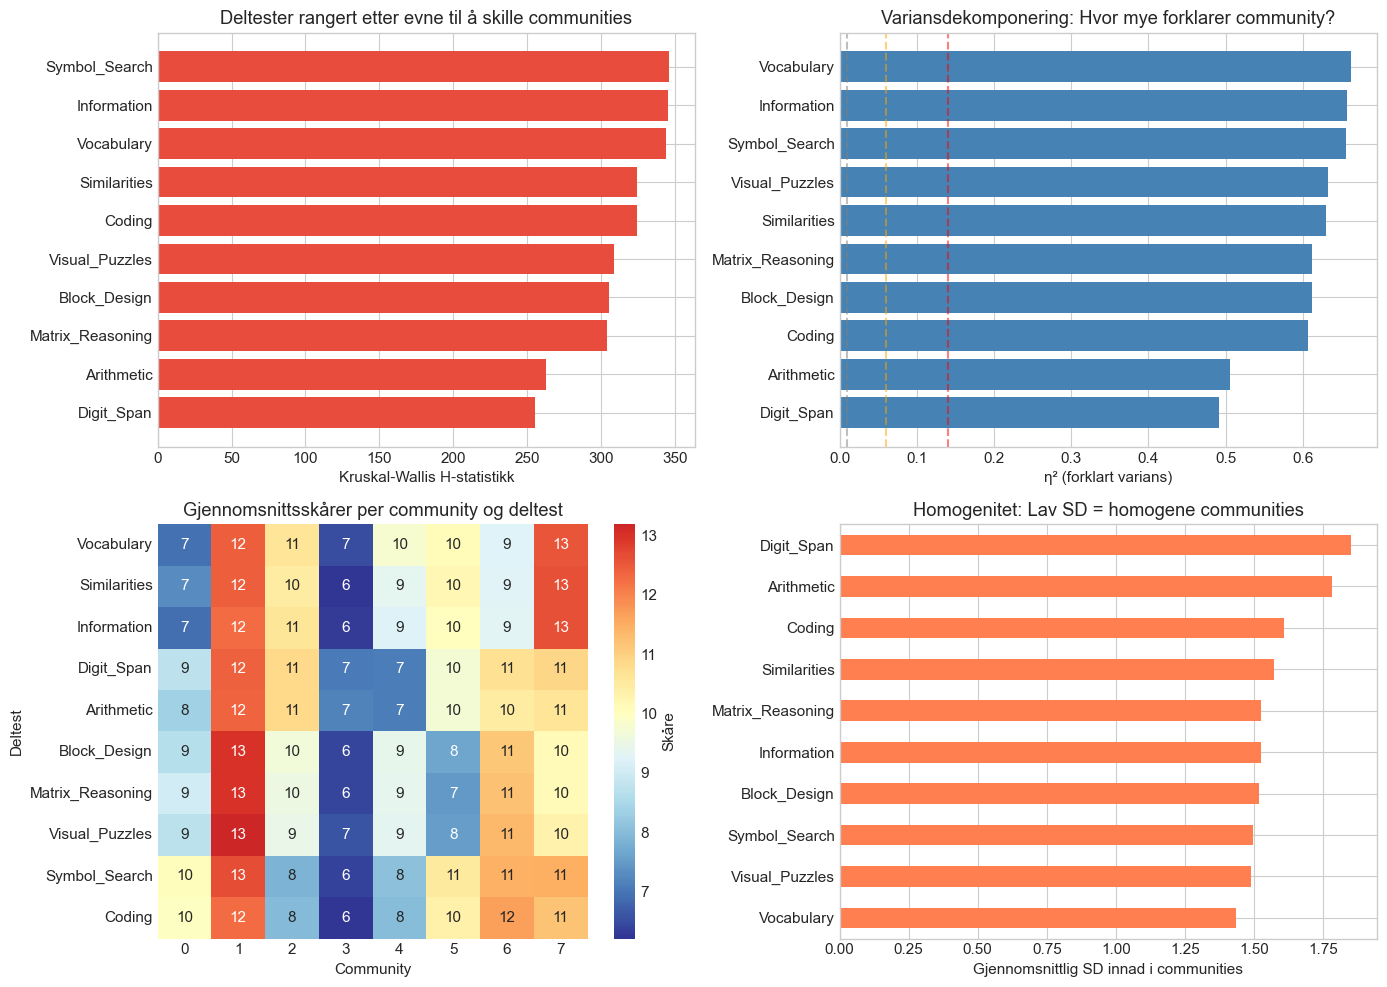


Figur: Analyse av deltestenes bidrag til community-struktur.


In [9]:
# ============================================================================
# OPPGAVE 3: VARIANSDEKOMPONERING OG VISUALISERING
# ============================================================================

# --- Metode 2: Eta-squared (effektstørrelse) ---
def eta_squared(groups):
    """Beregn eta-squared som mål på forklart varians."""
    all_data = np.concatenate(groups)
    grand_mean = np.mean(all_data)
    ss_between = sum(len(g) * (np.mean(g) - grand_mean)**2 for g in groups)
    ss_total = sum((x - grand_mean)**2 for x in all_data)
    return ss_between / ss_total if ss_total > 0 else 0

eta_results = []
for subtest in ALL_SUBTESTS:
    groups = [df[df['Community_Item'] == c][subtest].values 
              for c in sorted(set(partition_item.values()))]
    eta_sq = eta_squared(groups)
    eta_results.append({'Deltest': subtest, 'η²': eta_sq})

eta_df = pd.DataFrame(eta_results).sort_values('η²', ascending=False)

# --- Visualisering ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Rangering av deltester (H-statistikk)
ax1 = axes[0, 0]
kw_sorted = kw_df.sort_values('H-statistikk', ascending=True)
colors = ['#e74c3c' if s == '***' else '#f39c12' if s == '**' else '#3498db' if s == '*' else '#95a5a6' 
          for s in kw_sorted['Signifikant']]
ax1.barh(kw_sorted['Deltest'], kw_sorted['H-statistikk'], color=colors)
ax1.set_xlabel('Kruskal-Wallis H-statistikk')
ax1.set_title('Deltester rangert etter evne til å skille communities')

# 2. Eta-squared
ax2 = axes[0, 1]
eta_sorted = eta_df.sort_values('η²', ascending=True)
ax2.barh(eta_sorted['Deltest'], eta_sorted['η²'], color='steelblue')
ax2.set_xlabel('η² (forklart varians)')
ax2.set_title('Variansdekomponering: Hvor mye forklarer community?')
ax2.axvline(0.01, color='gray', linestyle='--', alpha=0.5, label='Liten effekt')
ax2.axvline(0.06, color='orange', linestyle='--', alpha=0.5, label='Medium effekt')
ax2.axvline(0.14, color='red', linestyle='--', alpha=0.5, label='Stor effekt')

# 3. Heatmap av community-profiler
ax3 = axes[1, 0]
community_means = df.groupby('Community_Item')[ALL_SUBTESTS].mean()
sns.heatmap(community_means.T, cmap='RdYlBu_r', center=10, ax=ax3,
            cbar_kws={'label': 'Skåre'}, annot=True, fmt='.0f')
ax3.set_xlabel('Community')
ax3.set_ylabel('Deltest')
ax3.set_title('Gjennomsnittsskårer per community og deltest')

# 4. Standardavvik per deltest per community (spredning)
ax4 = axes[1, 1]
community_std = df.groupby('Community_Item')[ALL_SUBTESTS].std().mean()
community_std.sort_values(ascending=True).plot(kind='barh', ax=ax4, color='coral')
ax4.set_xlabel('Gjennomsnittlig SD innad i communities')
ax4.set_title('Homogenitet: Lav SD = homogene communities')

plt.tight_layout()
plt.show()

print("\nFigur: Analyse av deltestenes bidrag til community-struktur.")


### 💡 Konklusjon Oppgave 3

**Tolkning av resultatene:**

| Metrikk | Hva den viser | Høy verdi betyr |
|---------|---------------|-----------------|
| **H-statistikk** | Forskjell mellom communities | Deltesten skiller godt |
| **η² (eta-squared)** | Forklart varians | Mye av variasjonen skyldes community |
| **SD innad** | Homogenitet | Lav SD = communities er homogene på denne testen |

**Forventede funn (basert på simuleringsmodellen):**

1. **Alle deltester bør bidra** fordi vi simulerte en g-faktor som påvirker alle
2. **Deltester innen samme indeks** bør korrelere (domene-faktor)
3. **PSI-tester** kan skille ekstra godt pga. alderseffekter

**Klinisk relevans:**

- Hvis visse deltester dominerer → fokuser på disse i screening
- Hvis alle bidrar likt → full WAIS-IV er nødvendig
- Mønsteret kan variere mellom populasjoner (f.eks. ADHD vs. demens)

---


<a id="refleksjon"></a>
## 💭 Refleksjonsspørsmål med drøftinger

Her følger drøftinger av de fire refleksjonsspørsmålene fra hovednotebooken.

---

### Refleksjon 1: Klinisk validitet

> **Hvordan ville du validere at PSN-baserte grupperinger er klinisk meningsfulle?**

#### Drøfting

**Valideringsstrategier:**

| Strategi | Beskrivelse | Eksempel |
|----------|-------------|----------|
| **Ekstern validering** | Sammenlign communities med kjente diagnoser | Korrelerer community-tilhørighet med ADHD/demens-diagnose? |
| **Prediktiv validitet** | Predikerer community utfall? | Responderer community X bedre på behandling Y? |
| **Kliniker-vurdering** | Eksperter vurderer om grupperingene gir mening | "Ja, dette minner om pasienter med visuospatial svikt" |
| **Stabilitet** | Test-retest: Havner pasienten i samme community? | Reliabilitet over tid |
| **Konvergent validitet** | Sammenlign med andre mål | Korrelerer med livskvalitet, funksjonsnivå? |

**Kritiske spørsmål:**
- Er communities bare artefakter av algoritmevalg?
- Ville en annen k-verdi gitt andre grupper?
- Er gruppene klinisk handlingsbare?

---

### Refleksjon 2: Etiske hensyn

> **Hvilke etiske utfordringer ser du med å bruke PSN for presisjonsnevropsykologi?**

#### Drøfting

| Utfordring | Beskrivelse | Tiltak |
|------------|-------------|--------|
| **Stigmatisering** | "Du tilhører lav-IQ-gruppen" | Unngå slik kommunikasjon; fokus på profil |
| **Determinisme** | "Pasienter som deg klarer ikke X" | Anerkjenn individuell variasjon |
| **Personvern** | Kognitiv profil er sensitiv informasjon | GDPR-compliant lagring |
| **Algoritmisk bias** | Simuleringen/algoritmen kan ha skjevheter | Transparent dokumentasjon |
| **Tilgang** | Avanserte analyser kun for ressurssterke? | Likeverdig helsetilbud |
| **Overfortolkning** | PSN er hypotesegenererende, ikke diagnostisk | Klar kommunikasjon om usikkerhet |

**Balanse:** PSN kan bidra til bedre behandling, men må brukes med varsomhet og respekt for individet.

---

### Refleksjon 3: HI vs. AI og g-faktoren

> **Tror du AI noen gang vil ha en "g-faktor"? Hvorfor/hvorfor ikke?**

#### Drøfting

**Argumenter FOR at AI kan utvikle en g-faktor:**

1. **Emergent generalitet**: Store modeller (GPT-4) viser evner på tvers av domener
2. **Transfer learning**: Samme modell løser mange ulike oppgaver
3. **Skalering**: Større modeller → bredere kapasitet
4. **Korrelasjon mellom benchmarks**: Modeller som er gode på ett område, er ofte gode på andre

**Argumenter MOT:**

1. **Arkitekturavhengig**: AI-evner avhenger av design, ikke biologisk substrat
2. **Ingen sentral prosessor**: Mennesker har hjernen; AI har distribuert beregning
3. **Mangel på embodiment**: AI mangler sensorimotorisk erfaring
4. **g-faktor er operasjonelt**: Definert av menneskelig testprestasjon

**Konklusjon:** AI kan vise *funksjonell* generalitet, men om dette er analogt til menneskelig g-faktor er et dypt filosofisk spørsmål. "G-faktor" er kanskje ikke det riktige begrepet for AI – vi trenger nye konsepter.

---

### Refleksjon 4: Fremtiden - Multimodal PSN

> **Hvordan kan PSN kombineres med andre datakilder (bildediagnostikk, genetikk) for enda bedre pasient-matching?**

#### Drøfting

**Potensielle datakilder:**

| Datakilde | Hva den tilfører | Utfordringer |
|-----------|------------------|--------------|
| **MRI (strukturell)** | Hjerneanatomi, atrofi | Kostnad, tilgjengelighet |
| **fMRI (funksjonell)** | Nettverksaktivitet | Kompleks tolkning |
| **Genetikk (GWAS)** | Sårbarhet, farmakogenomikk | Etikk, determinisme |
| **Biomarkører** | CSF, blodprøver | Invasivt (CSF) |
| **Livsstilsdata** | Søvn, aktivitet, kosthold | Personvern |
| **Elektronisk journal** | Historikk, komorbiditet | Strukturering, kvalitet |

**Teknisk tilnærming:**

```
               ┌─────────────────┐
               │   Multimodal    │
               │   Fusjon        │
               └────────┬────────┘
                        │
    ┌───────────┬───────┼───────┬───────────┐
    │           │       │       │           │
┌───┴───┐   ┌───┴───┐ ┌─┴─┐ ┌───┴───┐   ┌───┴───┐
│ WAIS  │   │ MRI   │ │DNA│ │ Bio   │   │ EHR   │
│ -IV   │   │       │ │   │ │ mark  │   │       │
└───────┘   └───────┘ └───┘ └───────┘   └───────┘
```

**Metoder:**
- **Weighted PSN**: Kombiner likhetmatriser fra ulike kilder
- **Multi-view clustering**: Felles community detection på tvers av modaliteter
- **Dyp læring**: Autoenkodere for representasjonslæring

**Visjon:** "Pasienter som ligner deg på kognitiv profil, hjerneanatomi og genetikk responderte best på..."

---


## 📚 Oppsummering

### Hva har vi lært i denne løsningsnotebooken?

| Oppgave | Hovedfunn | Klinisk implikasjon |
|---------|-----------|---------------------|
| **1. k_nearest** | Antall communities avtar med k; modularitet også | Valg av k påvirker granularitet |
| **2. Alderseffekter** | Ulike profiler for unge vs. eldre | Aldersspesifikke PSN kan være nyttige |
| **3. Deltester** | Alle bidrar (g-faktor); noen mer enn andre | Full WAIS-IV gir mest informasjon |

### Refleksjoner

- **Klinisk validering** er essensielt før PSN brukes i praksis
- **Etiske hensyn** må vurderes nøye (stigma, personvern)
- **HI vs. AI** parallellen er tankevekkende men ufullstendig
- **Multimodale data** er fremtiden for presisjonsnevropsykologi

### Neste steg

1. Prøv med ekte WAIS-IV data (hvis tilgjengelig)
2. Sammenlign ulike community-algoritmer
3. Utforsk multimodal integrasjon
4. Valider mot kliniske utfall

---

*Løsningsnotebook for ELMED219 - Kunstig intelligens og beregningsbasert medisin, 2026*
